In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Установка компонентов

In [ ]:
!pip install SimpleITK
!pip install torchmetrics
!pip install progress

Модель UNet

In [3]:
import torch
import torch.nn as nn

#Двойная свертка
def double_convolution(in_channels, out_channels):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
        )
    return conv_op


class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Сужение.
        # Каждая свертка применяется дважды.
        self.down_convolution_1 = double_convolution(1, 64)# 1 или 3?
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        # Расширение.
        self.up_transpose_1 = nn.ConvTranspose2d( in_channels=1024,
                                                  out_channels=512,
                                                  kernel_size=2,
                                                  stride=2)


        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d( in_channels=512,
                                                  out_channels=256,
                                                  kernel_size=2,
                                                  stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d( in_channels=256,
                                                  out_channels=128,
                                                  kernel_size=2,
                                                  stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d( in_channels=128,
                                                  out_channels=64,
                                                  kernel_size=2,
                                                  stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(in_channels=64,
                             out_channels=num_classes,
                             kernel_size=1)
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)


        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out


Распределение файлов на тренировочную, валидационную и тестовую

In [6]:
from pathlib import Path
import random
content_path = "/content/drive/MyDrive/SegTHOR_DB"
content_directory = Path(content_path)
ids = content_directory.glob('*_image*')
ids = [id.stem for id in ids]
ids = [id.split('_')[0] for id in ids]
ids = sorted(map(int, ids))
train_count = len(ids)*6//10
train_ids = random.sample(ids, train_count)
val_ids=list(set(ids)-set(train_ids))
val_count = len(val_ids)//2
val_ids = random.sample(val_ids, val_count)
test_ids = list(set(ids)-set(train_ids)-set(val_ids))
print(train_ids)
print(val_ids)
print(test_ids)

[22, 1, 33, 2, 4, 39, 5, 37, 10, 17, 6, 8, 14, 21, 29, 32, 18, 24, 28, 30, 13, 36, 7, 3]
[11, 27, 31, 12, 15, 35, 23, 19]
[34, 38, 40, 9, 16, 20, 25, 26]


Функция для расчета IoU метрики

In [7]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = (intersection) / (union)

    return iou

Подключение библиотек

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as func
import PIL.ImageOps
from torch import nn
from torchvision import datasets,transforms
import SimpleITK as itk
from torchmetrics.detection import IntersectionOverUnion as IoU
from tqdm import tqdm

Объявление гипер параметров

In [9]:
#https://pythonpip.ru/pytorch/obuchenie-modeli-svertochnoy-neyronnoy-seti
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=UNet().to(device)
criteron=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.00001)
epochs=8
metric_IoU = IoU()
loss_history=[]
metric_history=[]
correct_history=[]
val_loss_history=[]
val_metric_history=[]
val_correct_history=[]
model_history=[]
path="/content/drive/MyDrive/SegTHOR_DB"


transform = transforms.Compose([
    transforms.ToTensor()
])

Обучение модели

In [10]:
for e in range(epochs):
    loss = 0.0
    correct = 0.0
    val_loss=0.0
    val_correct=0.0
    metric = 0.0
    val_metric = 0.0
    for num_file in tqdm(train_ids):

        itk_img = itk.ReadImage(f'{path}/{num_file}_image.nii.gz')
        img = itk.GetArrayFromImage(itk_img)
        itk_img = itk.ReadImage(f'{path}/{num_file}_label.nii.gz')
        msk = itk.GetArrayFromImage(itk_img)

        for num_image in range(0, img.shape[0], 1):

            image = np.array(img[num_image].copy())
            image_tensor = transform(image).float()
            image_tensor = image_tensor.to(device)


            mask = np.array(msk[num_image], dtype=np.float32)

            mask_tensor = transform(mask).float()
            mask_tensor=mask_tensor.to(device)


            outputs = model(image_tensor.unsqueeze(0))
            loss1 = criteron(outputs, mask_tensor.unsqueeze(0))
            metric1=iou_pytorch(outputs,mask_tensor)

            optimizer.zero_grad()
            loss1.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            loss1=loss1.to(device)
            loss += loss1.item()
            metric += metric1.item()
            correct += torch.sum(preds == mask_tensor.data)

    else: #val
        with torch.no_grad():
            for val_num_file in tqdm(val_ids):

              itk_img = itk.ReadImage(f'{path}/{val_num_file}_image.nii.gz')
              img = itk.GetArrayFromImage(itk_img)
              itk_img = itk.ReadImage(f'{path}/{val_num_file}_label.nii.gz')
              msk = itk.GetArrayFromImage(itk_img)

              for num_image in range(0, img.shape[0], 1):

                  image = np.array(img[num_image].copy())
                  image_tensor = transform(image).float()
                  image_tensor = image_tensor.to(device)


                  mask = np.array(msk[num_image], dtype=np.float32)

                  mask_tensor = transform(mask).float()
                  mask_tensor=mask_tensor.to(device)

                  val_outputs = model(image_tensor.unsqueeze(0))
                  val_loss1 = criteron(val_outputs, mask_tensor.unsqueeze(0))
                  val_metric1=iou_pytorch(val_outputs, mask_tensor)
                  optimizer.zero_grad()
                  _, val_preds = torch.max(val_outputs, 1)
                  val_loss += val_loss1.item()
                  val_metric += val_metric1.item()
                  val_correct += torch.sum(val_preds == mask_tensor.data)


        epoch_loss=loss/len(train_ids)
        epoch_acc=correct.float()/len(train_ids)
        epoch_metric=metric/len(train_ids)
        #print("ep met")
        #print(epoch_metric)
        loss_history.append(epoch_loss)
        metric_history.append(epoch_metric)
        correct_history.append(epoch_acc)
        val_epoch_loss=val_loss/len(val_ids)
        val_epoch_acc=val_correct.float()/len(val_ids)
        val_epoch_metric=val_metric/len(val_ids)
        val_loss_history.append(val_epoch_loss)
        val_metric_history.append(epoch_metric)
        val_correct_history.append(val_epoch_acc)
        model_history.append(model)
        print('training_loss:{:.4f},{:.4f}'.format(epoch_loss,epoch_acc.item()))
        print('validation_loss:{:.4f},{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))


100%|██████████| 4/4 [01:13<00:00, 18.35s/it]


training_loss:4.8018,26864404.0000
validation_loss:0.9938,23283412.0000


100%|██████████| 4/4 [01:03<00:00, 15.79s/it]


training_loss:0.4377,26864404.0000
validation_loss:0.7024,23283412.0000


100%|██████████| 4/4 [01:03<00:00, 15.77s/it]


training_loss:0.3509,26864404.0000
validation_loss:0.5917,23283412.0000


100%|██████████| 4/4 [01:05<00:00, 16.44s/it]


training_loss:0.2973,26864404.0000
validation_loss:0.4755,23283412.0000


100%|██████████| 4/4 [01:03<00:00, 15.86s/it]


training_loss:0.2532,26864404.0000
validation_loss:0.3796,23283412.0000


100%|██████████| 4/4 [01:05<00:00, 16.30s/it]


training_loss:0.2188,26864404.0000
validation_loss:0.3557,23283412.0000


100%|██████████| 4/4 [01:03<00:00, 15.90s/it]


training_loss:0.1852,26864404.0000
validation_loss:0.2999,23283412.0000


100%|██████████| 4/4 [01:02<00:00, 15.72s/it]

training_loss:0.1676,26864404.0000
validation_loss:0.2615,23283412.0000


Погрешнось обучения на тренировочной и валидационной выборке

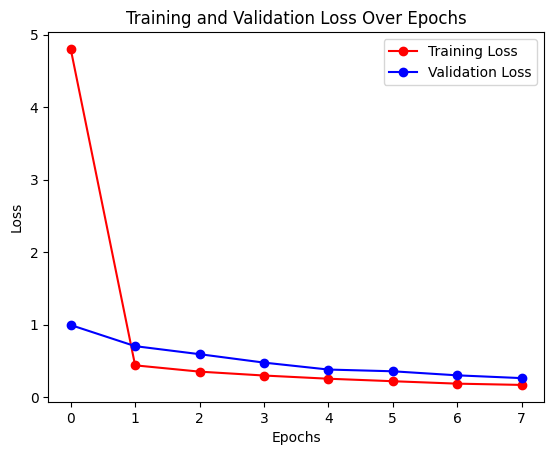

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_history, 'o-r', label='Training Loss')
plt.plot(val_loss_history, 'o-b', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

plt.legend()

plt.show()

Метрики обучения на валидационной выборке




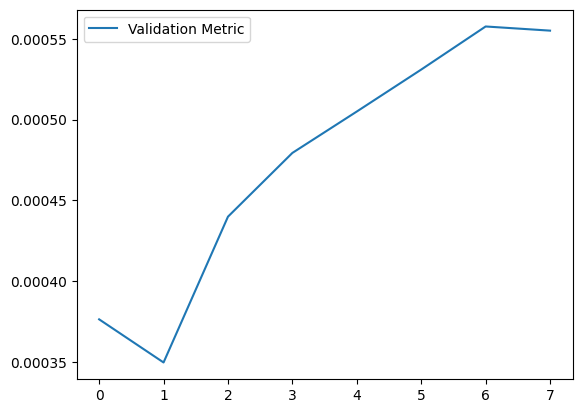

In [12]:
plt.plot(val_metric_history, label='Validation Metric')

plt.legend()

plt.show()

Нахождение минимальной погрешности

In [13]:
min_metric=min(metric_history)
id_min_metric=metric_history.index(min_metric)
print(min_metric)
print(id_min_metric)

0.0003497027500092287
1


Схранение лучших параметров модели в новую

In [14]:
torch.save(model_history[id_min_metric], 'model_min_loss1.pth')

In [16]:
model_min_metric = torch.load('model_min_loss1.pth')

Тестирование сохраненной модели

In [29]:
test_loss_history=[]
test_metric_history=[]
test_correct_history=[]

loss = 0.0
correct = 0.0
metric = 0.0
for num_file in tqdm(test_ids):
    loss = 0.0
    correct = 0.0
    metric = 0.0


    itk_img = itk.ReadImage(f'{path}/{num_file}_image.nii.gz')
    img = itk.GetArrayFromImage(itk_img)
    itk_img = itk.ReadImage(f'{path}/{num_file}_label.nii.gz')
    msk = itk.GetArrayFromImage(itk_img)

    temp=0
    for num_image in range(0, img.shape[0], 1):
        image = np.array(img[num_image].copy())

        image_tensor = transform(image).float()
        image_tensor = image_tensor.to(device)


        mask = np.array(msk[num_image], dtype=np.float32)

        mask_tensor = transform(mask).float()
        mask_tensor=mask_tensor.to(device)


        outputs = model_min_metric(image_tensor.unsqueeze(0))
        loss1 = criteron(outputs, mask_tensor.unsqueeze(0))
        metric1=iou_pytorch(outputs,mask_tensor)
        #metric1=metric_IoU(outputs.unsqueeze(0), mask_tensor.unsqueeze(0))
        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        loss1=loss1.to(device)
        loss += loss1.item()
        metric += metric1.item()
        correct += torch.sum(preds == mask_tensor.data)
        #print(temp)
        #temp+=1
    else:
        test_epoch_loss=loss/len(test_ids)
        test_epoch_acc=correct.float()/len(test_ids)
        test_epoch_metric=metric/len(test_ids)
        test_loss_history.append(test_epoch_loss)
        test_metric_history.append(test_epoch_metric)
        test_correct_history.append(test_epoch_acc)
        print('training_loss:{:.4f},{:.4f}'.format(test_epoch_loss,test_epoch_acc.item()))
        print('validation_loss:{:.4f},{:.4f}'.format(test_epoch_loss,test_epoch_acc.item()))


 12%|█▎        | 1/8 [00:40<04:43, 40.54s/it]

training_loss:0.0789,6280540.5000
validation_loss:0.0789,6280540.5000


 25%|██▌       | 2/8 [01:14<03:39, 36.50s/it]

training_loss:0.0593,5202614.0000
validation_loss:0.0593,5202614.0000


 38%|███▊      | 3/8 [01:57<03:18, 39.64s/it]

training_loss:0.0645,6641993.0000
validation_loss:0.0645,6641993.0000


 50%|█████     | 4/8 [02:31<02:29, 37.28s/it]

training_loss:0.0577,5038832.5000
validation_loss:0.0577,5038832.5000


 62%|██████▎   | 5/8 [03:09<01:53, 37.72s/it]

training_loss:0.0430,5430923.0000
validation_loss:0.0430,5430923.0000


 75%|███████▌  | 6/8 [03:55<01:21, 40.55s/it]

training_loss:0.0663,6744780.0000
validation_loss:0.0663,6744780.0000


 88%|████████▊ | 7/8 [04:30<00:38, 38.50s/it]

training_loss:0.0526,4906139.5000
validation_loss:0.0526,4906139.5000


100%|██████████| 8/8 [05:26<00:00, 40.77s/it]

training_loss:0.0742,8079997.5000
validation_loss:0.0742,8079997.5000


Погрешнось обучения тестовой выборки

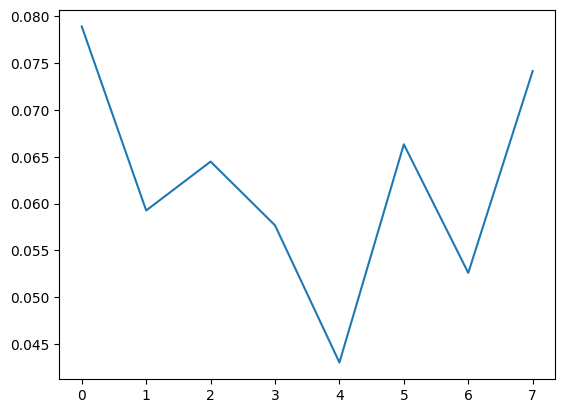

In [30]:
plt.plot(test_loss_history, label='Running Loss History')

Метрики обучения тестовой выборки

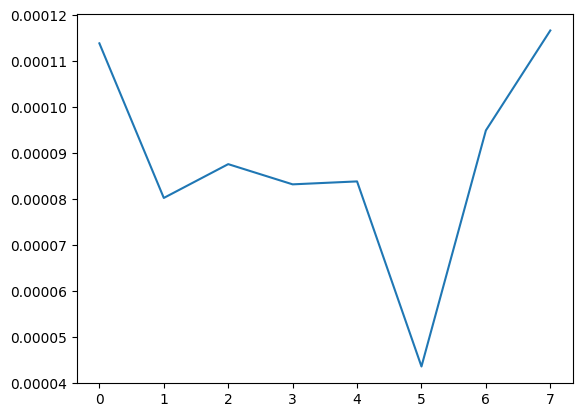

In [31]:
plt.plot(test_metric_history, label='Running Loss History')



---



---



---



---



Сохранение и загрузка модели

In [ ]:
torch.save(model, 'model3.pth')

In [27]:
path_on_drive = '/content/drive/MyDrive/unet_model/your_model3.pth'

# Сохранение модели
torch.save(model, path_on_drive)

In [ ]:
model = torch.load('model.pth')

Сохранение и загрузка параметров модели

In [ ]:
torch.save(model.state_dict(), 'model_parameters2.pth')

In [26]:
path_on_drive = '/content/drive/MyDrive/unet_model/your_model_parameters3.pth'

# Сохранение модели
torch.save(model.state_dict(), path_on_drive)

In [ ]:
model.load_state_dict(torch.load('model_parameters.pth'))

Сохранить  и загрузить состояние оптимизатора


In [ ]:
torch.save(optimizer.state_dict(), 'optimizer_state1.pth')

In [28]:
path_on_drive = '/content/drive/MyDrive/unet_model/optimizer3.pth'

# Сохранение состояния оптимизатора
torch.save(optimizer.state_dict(), path_on_drive)

In [ ]:
optimizer.load_state_dict(torch.load('optimizer_state.pth'))